In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision
import torch
import tensorflow as tf
from torch.utils import data

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=60000, shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=True)

sample = enumerate(trainloader)
batch_idx, (x_train, y_train) = next(sample)

sample = enumerate(testloader)
batch_idx, (x_test, y_test) = next(sample)

x_train = torch.reshape(x_train,(x_train.shape[0],x_train.shape[2]*x_train.shape[3]))
x_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[2]*x_test.shape[3]))

In [0]:
from sklearn.model_selection import train_test_split
x_train,remove_trainx, y_train, remove_trainy=train_test_split(x_train,y_train,test_size=0.83332,stratify=y_train,random_state=875)
trainset_new=data.TensorDataset(x_train,y_train)
trainloader=torch.utils.data.DataLoader(trainset_new, batch_size=100, shuffle=True)

In [0]:
LR = 0.001
EPOCH_NUM = 80
BATCH_SIZE = 100
K = [1,3,5,10,15,20,30,40]
prob = [0.0,0.5,0.9]
train_acc = np.zeros((len(K), len(prob), EPOCH_NUM))
test_acc = np.zeros((len(K), len(prob), EPOCH_NUM))
train_loss = np.zeros((len(K), len(prob), EPOCH_NUM))

#1. Code for running multiple values of K and p over MNIST model

In [0]:
for i in range(len(K)):
    for j in range(len(prob)):
        lin1 = torch.nn.Linear(784, K[i], bias=True)
        lin2 = torch.nn.Linear(K[i],10, bias=True)
        relu = torch.nn.ReLU()
        soft = torch.nn.Softmax(dim=1)
        drop = torch.nn.Dropout(p=prob[j])
        torch.nn.init.kaiming_normal_(lin1.weight, mode='fan_out', nonlinearity='relu')
        torch.nn.init.kaiming_normal_(lin2.weight, mode='fan_out', nonlinearity='relu')
        model = torch.nn.Sequential(lin1, relu, lin2, drop, soft).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)

        for e in range(EPOCH_NUM):
            loss  = 0
            model.train()
            for batch_idx, (data, target) in enumerate(trainloader):
                data = data.to(device)
                target = target.long().to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                loss += loss.item()
            train_loss[i,j,e] = loss/(batch_idx+1)
            all_ops = model(x_train.to(device))
            _, pred = all_ops.max(1)
            corr = pred.eq(y_train.long().to(device)).sum().item()/x_train.shape[0]
            train_acc[i,j,e] = 100*corr
            model.eval()
            test_ops = model(x_test.to(device))
            _, test_pred = test_ops.max(1)
            test_corr = test_pred.eq(y_test.long().to(device)).sum().item()/x_test.shape[0]
            test_acc[i,j,e] = 100*test_corr

For P = 1.0 Max train Accuracy: 97.63  at K =  40
For P = 1.0 Max Test Accuracy: 93.62  at K =  40


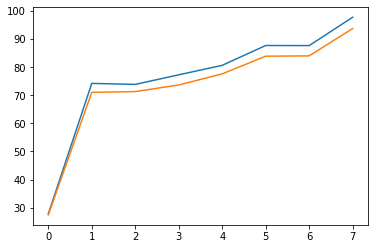

In [190]:
plt.figure()
x = np.unravel_index(np.argmax(train_acc[:,0,-1], axis=None), train_acc[:,0,-1].shape)
print("For P = 1.0", end=' ')
print('Max train Accuracy: {:.2f}'.format(np.max(train_acc[:,0,-1])),' at K = ',K[x[0]])
b = []
for i in range(len(K)):
    b.append(train_acc[i,0,-1])
plt.plot(b)
x = np.unravel_index(np.argmax(test_acc[:,0,-1], axis=None), test_acc[:,0,-1].shape)
print("For P = 1.0",end=' ')
print('Max Test Accuracy: {:.2f}'.format(np.max(test_acc[:,0,-1])),' at K = ',K[x[0]])
b = []
for i in range(len(K)):
    b.append(test_acc[i,0,-1])
plt.plot(b)
plt.show()

###2. a) As we can see as k increases the  training accuracy also increases, while k at k=40 the training accuracy is the maximum.

For P = 1.0 Max train Accuracy: 97.63  at K =  40
For P = 0.5 Max train Accuracy: 55.68  at K =  15
For P = 0.1 Max train Accuracy: 17.14  at K =  30


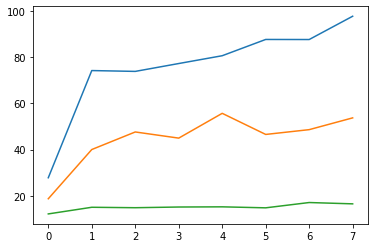

In [191]:
plt.figure()
for j in range(len(prob)):
    x = np.unravel_index(np.argmax(train_acc[:,j,-1], axis=None), train_acc[:,j,-1].shape)
    print('For P = {:.1f}'.format(1-prob[j]), end=' ')
    print('Max train Accuracy: {:.2f}'.format(np.max(train_acc[:,j,-1])),' at K = ',K[x[0]])
    b = []
    for i in range(len(K)):
        b.append(train_acc[i,j,-1])
    plt.plot(b)
plt.show()

###2. b) Plotting the train accuracy as a function of k , as P increase the accuracy seems to increase and we can see the max train accuracy for each p. Optimizing becomes difficult when p is small.


For P = 1.0 Max test Accuracy: 93.62  at K =  40
For P = 0.5 Max test Accuracy: 90.94  at K =  15
For P = 0.1 Max test Accuracy: 72.62  at K =  30


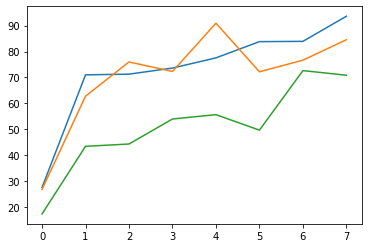

In [192]:
plt.figure()
for j in range(len(prob)):
    x = np.unravel_index(np.argmax(test_acc[:,j,-1], axis=None), test_acc[:,j,-1].shape)
    print('For P = {:.1f}'.format(1-prob[j]), end=' ')
    print('Max test Accuracy: {:.2f}'.format(np.max(test_acc[:,j,-1])),' at K = ',K[x[0]])
    b = []
    for i in range(len(K)):
        b.append(test_acc[i,j,-1])
    plt.plot(b)
plt.show()

###2. c) As the value of p increases the test accuracy increase. The best accuracy is for k=40 and p=1.0

#3. Adding noise to the 40% of the labels. 


In [0]:
import random
y_noise=y_train.numpy()

for i in range(4000):
  k=random.choice(r)
  if(k==y_noise[i]):
    y_noise[i]=random.choice(r)
  else:
    y_noise[i]=k

In [0]:
y_noise=torch.from_numpy(y_noise)

In [0]:
from torch.utils import data
trainsetnew=data.TensorDataset(x_train,y_noise)

In [0]:
trainloadernew = torch.utils.data.DataLoader(trainsetnew, batch_size=100, shuffle=True)

In [0]:
LR = 0.01
EPOCH_NUM = 80
BATCH_SIZE = 100
K = [1,3,5,10,15,20,30,40]
prob = [0.0,0.5,0.9]
train_acc = np.zeros((len(K), len(prob), EPOCH_NUM))
test_acc = np.zeros((len(K), len(prob), EPOCH_NUM))
train_loss = np.zeros((len(K), len(prob), EPOCH_NUM))

In [0]:
for i in range(len(K)):
    for j in range(len(prob)):
        linear1 = torch.nn.Linear(784, K[i], bias=True)
        linear2 = torch.nn.Linear(K[i],10, bias=True)
        relu = torch.nn.ReLU()
        soft = torch.nn.Softmax(dim=1)
        drop = torch.nn.Dropout(p=prob[j])
        torch.nn.init.kaiming_normal_(linear1.weight, mode='fan_out', nonlinearity='relu')
        torch.nn.init.kaiming_normal_(linear2.weight, mode='fan_out', nonlinearity='relu')
        model = torch.nn.Sequential(linear1, relu, linear2, drop, soft).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)

        for e in range(EPOCH_NUM):
            loss  = 0
            model.train()
            for batch_idx, (data, target) in enumerate(trainloadernew):
                data = data.to(device)
                target = target.long().to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                loss += loss.item()
            train_loss[i,j,e] = loss/(batch_idx+1)
            all_ops = model(x_train.to(device))
            _, pred = all_ops.max(1)
            corr = pred.eq(y_noise.long().to(device)).sum().item()/x_train.shape[0]
            train_acc[i,j,e] = 100*corr
            model.eval()
            test_ops = model(x_test.to(device))
            _, test_pred = test_ops.max(1)
            test_corr = test_pred.eq(y_test.long().to(device)).sum().item()/x_test.shape[0]
            test_acc[i,j,e] = 100*test_corr

For P = 1.0 Max train Accuracy: 57.41  at K =  15
For P = 1.0 Max Test Accuracy: 89.71  at K =  15


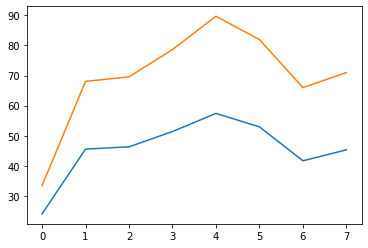

In [199]:
plt.figure()
x = np.unravel_index(np.argmax(train_acc[:,0,-1], axis=None), train_acc[:,0,-1].shape)
print("For P = 1.0", end=' ')
print('Max train Accuracy: {:.2f}'.format(np.max(train_acc[:,0,-1])),' at K = ',K[x[0]])
b = []
for i in range(len(K)):
    b.append(train_acc[i,0,-1])
plt.plot(b)
x = np.unravel_index(np.argmax(test_acc[:,0,-1], axis=None), test_acc[:,0,-1].shape)
print("For P = 1.0",end=' ')
print('Max Test Accuracy: {:.2f}'.format(np.max(test_acc[:,0,-1])),' at K = ',K[x[0]])
b = []
for i in range(len(K)):
    b.append(test_acc[i,0,-1])
plt.plot(b)
plt.show()

###3. a) As we can see as k increases the training accuracy also increases, while k at k=15 the training accuracy is the maximum.

For P = 1.0 Max train Accuracy: 57.41  at K =  15
For P = 0.5 Max train Accuracy: 30.14  at K =  5
For P = 0.1 Max train Accuracy: 11.90  at K =  3


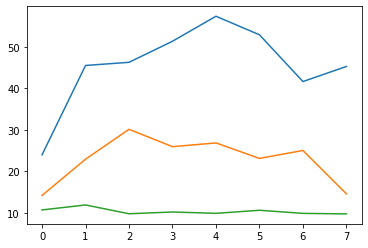

In [200]:
# Train accuracy for all values of K and P
plt.figure()
for j in range(len(prob)):
    x = np.unravel_index(np.argmax(train_acc[:,j,-1], axis=None), train_acc[:,j,-1].shape)
    print('For P = {:.1f}'.format(1-prob[j]), end=' ')
    print('Max train Accuracy: {:.2f}'.format(np.max(train_acc[:,j,-1])),' at K = ',K[x[0]])
    b = []
    for i in range(len(K)):
        b.append(train_acc[i,j,-1])
    plt.plot(b)
plt.show()

###3. b) Plotting the train accuracy as a function of k , as P increase the accuracy seems to increase and we can see the max train accuracy for each p. Optimizing becomes difficult when p is small.

For P = 1.0 Max test Accuracy: 89.71  at K =  15
For P = 0.5 Max test Accuracy: 71.56  at K =  5
For P = 0.1 Max test Accuracy: 25.64  at K =  3


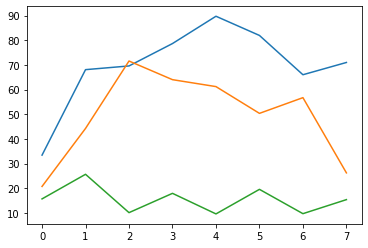

In [201]:
# Test accuracy for all values of K and P
plt.figure()
for j in range(len(prob)):
    x = np.unravel_index(np.argmax(test_acc[:,j,-1], axis=None), test_acc[:,j,-1].shape)
    print('For P = {:.1f}'.format(1-prob[j]), end=' ')
    print('Max test Accuracy: {:.2f}'.format(np.max(test_acc[:,j,-1])),' at K = ',K[x[0]])
    b = []
    for i in range(len(K)):
        b.append(test_acc[i,j,-1])
    plt.plot(b)
plt.show()

###3. c) As the value of p increases the test accuracy increase. The best accuracy is for k=15 and p=1.0

#4. Step 2 and Step 3 create a huge difference for training accuracy as it drops down when noise is added to the input. Droput turns to be more useful in the case of p being very small , which makes it essential for dropping out the unnecessary features which are not impactful for the outcome.